In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b10','b25','b50','b75'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_b10_b25_b50_b75_t1_mask_t1_normalized_k5_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 460)
(734160, 1)
validation
(101248, 460)
(101248, 1)
test
(100432, 460)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 460)]             0         


 dense (Dense)               (None, 1024)              472064    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1161217 (4.43 MB)


Trainable params: 1161217 (4.43 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:37 - loss: 0.0191 - STD: 6.3885e-05 - MAE: 0.1218

 4/74 [>.............................] - ETA: 1s - loss: 0.0168 - STD: 1.1929e-04 - MAE: 0.1012  

 8/74 [==>...........................] - ETA: 1s - loss: 0.0144 - STD: 9.7802e-05 - MAE: 0.0917

12/74 [===>..........................] - ETA: 1s - loss: 0.0135 - STD: 9.1104e-05 - MAE: 0.0915

16/74 [=====>........................] - ETA: 0s - loss: 0.0126 - STD: 8.7031e-05 - MAE: 0.0874

19/74 [======>.......................] - ETA: 0s - loss: 0.0123 - STD: 8.6127e-05 - MAE: 0.0855

23/74 [========>.....................] - ETA: 0s - loss: 0.0118 - STD: 8.9872e-05 - MAE: 0.0840

27/74 [=========>....................] - ETA: 0s - loss: 0.0115 - STD: 9.5566e-05 - MAE: 0.0835

31/74 [===========>..................] - ETA: 0s - loss: 0.0112 - STD: 9.9809e-05 - MAE: 0.0822

35/74 [=============>................] - ETA: 0s - loss: 0.0110 - STD: 1.0476e-04 - MAE: 0.0814

39/74 [==============>...............] - ETA: 0s - loss: 0.0108 - STD: 1.1163e-04 - MAE: 0.0809

42/74 [================>.............] - ETA: 0s - loss: 0.0107 - STD: 1.1689e-04 - MAE: 0.0805

46/74 [=================>............] - ETA: 0s - loss: 0.0106 - STD: 1.2347e-04 - MAE: 0.0800

50/74 [===================>..........] - ETA: 0s - loss: 0.0105 - STD: 1.3091e-04 - MAE: 0.0797

54/74 [====================>.........] - ETA: 0s - loss: 0.0104 - STD: 1.3930e-04 - MAE: 0.0794

58/74 [======================>.......] - ETA: 0s - loss: 0.0103 - STD: 1.4798e-04 - MAE: 0.0792

62/74 [========================>.....] - ETA: 0s - loss: 0.0102 - STD: 1.5716e-04 - MAE: 0.0789

66/74 [=========================>....] - ETA: 0s - loss: 0.0102 - STD: 1.6731e-04 - MAE: 0.0787

69/74 [==========================>...] - ETA: 0s - loss: 0.0101 - STD: 1.7533e-04 - MAE: 0.0785

72/74 [============================>.] - ETA: 0s - loss: 0.0101 - STD: 1.8362e-04 - MAE: 0.0784

74/74 [==============================] - 4s 35ms/step - loss: 0.0101 - STD: 1.8949e-04 - MAE: 0.0783 - val_loss: 0.0086 - val_STD: 3.1168e-04 - val_MAE: 0.0713


Epoch 2/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0094 - STD: 4.1542e-04 - MAE: 0.0755

 5/74 [=>............................] - ETA: 1s - loss: 0.0092 - STD: 4.4325e-04 - MAE: 0.0755

 9/74 [==>...........................] - ETA: 1s - loss: 0.0093 - STD: 4.6704e-04 - MAE: 0.0758

13/74 [====>.........................] - ETA: 0s - loss: 0.0093 - STD: 4.9203e-04 - MAE: 0.0758

17/74 [=====>........................] - ETA: 0s - loss: 0.0093 - STD: 5.2079e-04 - MAE: 0.0757

20/74 [=======>......................] - ETA: 0s - loss: 0.0093 - STD: 5.4400e-04 - MAE: 0.0756

23/74 [========>.....................] - ETA: 0s - loss: 0.0092 - STD: 5.7025e-04 - MAE: 0.0756

27/74 [=========>....................] - ETA: 0s - loss: 0.0092 - STD: 6.0612e-04 - MAE: 0.0755

31/74 [===========>..................] - ETA: 0s - loss: 0.0092 - STD: 6.4695e-04 - MAE: 0.0754

35/74 [=============>................] - ETA: 0s - loss: 0.0092 - STD: 6.9352e-04 - MAE: 0.0754

39/74 [==============>...............] - ETA: 0s - loss: 0.0092 - STD: 7.4452e-04 - MAE: 0.0754

43/74 [================>.............] - ETA: 0s - loss: 0.0092 - STD: 8.0369e-04 - MAE: 0.0753

47/74 [==================>...........] - ETA: 0s - loss: 0.0092 - STD: 8.7168e-04 - MAE: 0.0753

51/74 [===================>..........] - ETA: 0s - loss: 0.0092 - STD: 9.4691e-04 - MAE: 0.0753

55/74 [=====================>........] - ETA: 0s - loss: 0.0092 - STD: 0.0010 - MAE: 0.0753    

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 0.0011 - MAE: 0.0753

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 0.0012 - MAE: 0.0752

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 0.0014 - MAE: 0.0752

70/74 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 0.0015 - MAE: 0.0752

74/74 [==============================] - ETA: 0s - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751

74/74 [==============================] - 1s 18ms/step - loss: 0.0091 - STD: 0.0017 - MAE: 0.0751 - val_loss: 0.0082 - val_STD: 0.0044 - val_MAE: 0.0700


Epoch 3/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0744

 5/74 [=>............................] - ETA: 1s - loss: 0.0088 - STD: 0.0065 - MAE: 0.0740

 8/74 [==>...........................] - ETA: 1s - loss: 0.0088 - STD: 0.0072 - MAE: 0.0742

12/74 [===>..........................] - ETA: 0s - loss: 0.0088 - STD: 0.0081 - MAE: 0.0740

16/74 [=====>........................] - ETA: 0s - loss: 0.0087 - STD: 0.0092 - MAE: 0.0737

20/74 [=======>......................] - ETA: 0s - loss: 0.0086 - STD: 0.0104 - MAE: 0.0734

24/74 [========>.....................] - ETA: 0s - loss: 0.0086 - STD: 0.0118 - MAE: 0.0733

28/74 [==========>...................] - ETA: 0s - loss: 0.0085 - STD: 0.0134 - MAE: 0.0731

33/74 [============>.................] - ETA: 0s - loss: 0.0084 - STD: 0.0155 - MAE: 0.0727

37/74 [==============>...............] - ETA: 0s - loss: 0.0084 - STD: 0.0171 - MAE: 0.0724

41/74 [===============>..............] - ETA: 0s - loss: 0.0083 - STD: 0.0186 - MAE: 0.0721

45/74 [=================>............] - ETA: 0s - loss: 0.0082 - STD: 0.0201 - MAE: 0.0717

49/74 [==================>...........] - ETA: 0s - loss: 0.0081 - STD: 0.0214 - MAE: 0.0714

53/74 [====================>.........] - ETA: 0s - loss: 0.0081 - STD: 0.0226 - MAE: 0.0710

57/74 [======================>.......] - ETA: 0s - loss: 0.0080 - STD: 0.0238 - MAE: 0.0707

61/74 [=======================>......] - ETA: 0s - loss: 0.0080 - STD: 0.0248 - MAE: 0.0704

65/74 [=========================>....] - ETA: 0s - loss: 0.0079 - STD: 0.0258 - MAE: 0.0701

69/74 [==========================>...] - ETA: 0s - loss: 0.0079 - STD: 0.0268 - MAE: 0.0699

73/74 [============================>.] - ETA: 0s - loss: 0.0078 - STD: 0.0277 - MAE: 0.0696

74/74 [==============================] - 1s 18ms/step - loss: 0.0078 - STD: 0.0279 - MAE: 0.0695 - val_loss: 0.0062 - val_STD: 0.0313 - val_MAE: 0.0585


Epoch 4/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0425 - MAE: 0.0618

 4/74 [>.............................] - ETA: 1s - loss: 0.0067 - STD: 0.0447 - MAE: 0.0632

 8/74 [==>...........................] - ETA: 1s - loss: 0.0066 - STD: 0.0458 - MAE: 0.0631

12/74 [===>..........................] - ETA: 0s - loss: 0.0065 - STD: 0.0466 - MAE: 0.0627

17/74 [=====>........................] - ETA: 0s - loss: 0.0065 - STD: 0.0475 - MAE: 0.0623

20/74 [=======>......................] - ETA: 0s - loss: 0.0065 - STD: 0.0480 - MAE: 0.0622

24/74 [========>.....................] - ETA: 0s - loss: 0.0064 - STD: 0.0487 - MAE: 0.0621

28/74 [==========>...................] - ETA: 0s - loss: 0.0064 - STD: 0.0493 - MAE: 0.0620

32/74 [===========>..................] - ETA: 0s - loss: 0.0064 - STD: 0.0499 - MAE: 0.0620

35/74 [=============>................] - ETA: 0s - loss: 0.0064 - STD: 0.0502 - MAE: 0.0619

39/74 [==============>...............] - ETA: 0s - loss: 0.0064 - STD: 0.0506 - MAE: 0.0617

43/74 [================>.............] - ETA: 0s - loss: 0.0064 - STD: 0.0509 - MAE: 0.0617

46/74 [=================>............] - ETA: 0s - loss: 0.0064 - STD: 0.0511 - MAE: 0.0617

50/74 [===================>..........] - ETA: 0s - loss: 0.0064 - STD: 0.0513 - MAE: 0.0616

54/74 [====================>.........] - ETA: 0s - loss: 0.0064 - STD: 0.0514 - MAE: 0.0615

58/74 [======================>.......] - ETA: 0s - loss: 0.0064 - STD: 0.0516 - MAE: 0.0614

62/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0518 - MAE: 0.0614

65/74 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0519 - MAE: 0.0613

69/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0521 - MAE: 0.0613

73/74 [============================>.] - ETA: 0s - loss: 0.0063 - STD: 0.0522 - MAE: 0.0612

74/74 [==============================] - 1s 18ms/step - loss: 0.0063 - STD: 0.0523 - MAE: 0.0613 - val_loss: 0.0055 - val_STD: 0.0391 - val_MAE: 0.0554


Epoch 5/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0059 - STD: 0.0540 - MAE: 0.0585

 5/74 [=>............................] - ETA: 0s - loss: 0.0062 - STD: 0.0551 - MAE: 0.0602

 8/74 [==>...........................] - ETA: 0s - loss: 0.0061 - STD: 0.0550 - MAE: 0.0600

12/74 [===>..........................] - ETA: 0s - loss: 0.0061 - STD: 0.0551 - MAE: 0.0599

15/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0549 - MAE: 0.0600

19/74 [======>.......................] - ETA: 0s - loss: 0.0062 - STD: 0.0550 - MAE: 0.0603

22/74 [=======>......................] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0603

26/74 [=========>....................] - ETA: 0s - loss: 0.0062 - STD: 0.0548 - MAE: 0.0604

30/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0545 - MAE: 0.0605

34/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0541 - MAE: 0.0606

38/74 [==============>...............] - ETA: 0s - loss: 0.0063 - STD: 0.0540 - MAE: 0.0609

41/74 [===============>..............] - ETA: 0s - loss: 0.0063 - STD: 0.0536 - MAE: 0.0609

45/74 [=================>............] - ETA: 0s - loss: 0.0063 - STD: 0.0533 - MAE: 0.0610

49/74 [==================>...........] - ETA: 0s - loss: 0.0063 - STD: 0.0530 - MAE: 0.0610

52/74 [====================>.........] - ETA: 0s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0610

56/74 [=====================>........] - ETA: 0s - loss: 0.0063 - STD: 0.0526 - MAE: 0.0610

60/74 [=======================>......] - ETA: 0s - loss: 0.0063 - STD: 0.0526 - MAE: 0.0609

64/74 [========================>.....] - ETA: 0s - loss: 0.0063 - STD: 0.0527 - MAE: 0.0609

68/74 [==========================>...] - ETA: 0s - loss: 0.0063 - STD: 0.0528 - MAE: 0.0608

72/74 [============================>.] - ETA: 0s - loss: 0.0062 - STD: 0.0530 - MAE: 0.0608

74/74 [==============================] - 1s 18ms/step - loss: 0.0062 - STD: 0.0530 - MAE: 0.0607 - val_loss: 0.0055 - val_STD: 0.0407 - val_MAE: 0.0548


Epoch 6/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0592

 5/74 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0597

 9/74 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0573 - MAE: 0.0595

13/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0594

17/74 [=====>........................] - ETA: 0s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0593

20/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0593

24/74 [========>.....................] - ETA: 0s - loss: 0.0060 - STD: 0.0572 - MAE: 0.0592

28/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0593

32/74 [===========>..................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

36/74 [=============>................] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

39/74 [==============>...............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

42/74 [================>.............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

46/74 [=================>............] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

50/74 [===================>..........] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0592

54/74 [====================>.........] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0591

57/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0591

61/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0591

64/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0590

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0572 - MAE: 0.0590

73/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0571 - MAE: 0.0591

74/74 [==============================] - 1s 18ms/step - loss: 0.0059 - STD: 0.0572 - MAE: 0.0591 - val_loss: 0.0053 - val_STD: 0.0434 - val_MAE: 0.0553


Epoch 7/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0597 - MAE: 0.0608

 5/74 [=>............................] - ETA: 1s - loss: 0.0060 - STD: 0.0565 - MAE: 0.0595

 9/74 [==>...........................] - ETA: 1s - loss: 0.0060 - STD: 0.0563 - MAE: 0.0593

13/74 [====>.........................] - ETA: 0s - loss: 0.0060 - STD: 0.0564 - MAE: 0.0599

17/74 [=====>........................] - ETA: 0s - loss: 0.0061 - STD: 0.0560 - MAE: 0.0598

21/74 [=======>......................] - ETA: 0s - loss: 0.0060 - STD: 0.0556 - MAE: 0.0596

25/74 [=========>....................] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0596

28/74 [==========>...................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0596

31/74 [===========>..................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0595

35/74 [=============>................] - ETA: 0s - loss: 0.0060 - STD: 0.0553 - MAE: 0.0595

38/74 [==============>...............] - ETA: 0s - loss: 0.0060 - STD: 0.0554 - MAE: 0.0594

42/74 [================>.............] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0594

46/74 [=================>............] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0593

51/74 [===================>..........] - ETA: 0s - loss: 0.0060 - STD: 0.0558 - MAE: 0.0593

54/74 [====================>.........] - ETA: 0s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0592

58/74 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0561 - MAE: 0.0592

61/74 [=======================>......] - ETA: 0s - loss: 0.0059 - STD: 0.0562 - MAE: 0.0592

64/74 [========================>.....] - ETA: 0s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0591

68/74 [==========================>...] - ETA: 0s - loss: 0.0059 - STD: 0.0564 - MAE: 0.0590

72/74 [============================>.] - ETA: 0s - loss: 0.0059 - STD: 0.0565 - MAE: 0.0590

74/74 [==============================] - 1s 18ms/step - loss: 0.0059 - STD: 0.0566 - MAE: 0.0590 - val_loss: 0.0056 - val_STD: 0.0419 - val_MAE: 0.0543


Epoch 8/10000


 1/74 [..............................] - ETA: 4s - loss: 0.0060 - STD: 0.0571 - MAE: 0.0593

 5/74 [=>............................] - ETA: 1s - loss: 0.0059 - STD: 0.0585 - MAE: 0.0588

 9/74 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0583 - MAE: 0.0586

12/74 [===>..........................] - ETA: 1s - loss: 0.0058 - STD: 0.0584 - MAE: 0.0585

16/74 [=====>........................] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0583

20/74 [=======>......................] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0583

24/74 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0581 - MAE: 0.0583

28/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0584

32/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0584

36/74 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0580 - MAE: 0.0584

39/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0579 - MAE: 0.0584

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0584

46/74 [=================>............] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0584

50/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0584

54/74 [====================>.........] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0584

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0584

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0577 - MAE: 0.0585

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585

74/74 [==============================] - 1s 18ms/step - loss: 0.0058 - STD: 0.0576 - MAE: 0.0585 - val_loss: 0.0063 - val_STD: 0.0394 - val_MAE: 0.0559


Epoch 9/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0060 - STD: 0.0532 - MAE: 0.0574

 4/74 [>.............................] - ETA: 1s - loss: 0.0060 - STD: 0.0559 - MAE: 0.0586

 8/74 [==>...........................] - ETA: 1s - loss: 0.0059 - STD: 0.0563 - MAE: 0.0588

12/74 [===>..........................] - ETA: 1s - loss: 0.0062 - STD: 0.0568 - MAE: 0.0603

16/74 [=====>........................] - ETA: 0s - loss: 0.0063 - STD: 0.0556 - MAE: 0.0609

19/74 [======>.......................] - ETA: 0s - loss: 0.0064 - STD: 0.0551 - MAE: 0.0611

23/74 [========>.....................] - ETA: 0s - loss: 0.0063 - STD: 0.0541 - MAE: 0.0609

27/74 [=========>....................] - ETA: 0s - loss: 0.0063 - STD: 0.0535 - MAE: 0.0607

30/74 [===========>..................] - ETA: 0s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0606

34/74 [============>.................] - ETA: 0s - loss: 0.0062 - STD: 0.0532 - MAE: 0.0605

38/74 [==============>...............] - ETA: 0s - loss: 0.0062 - STD: 0.0533 - MAE: 0.0603

41/74 [===============>..............] - ETA: 0s - loss: 0.0061 - STD: 0.0534 - MAE: 0.0601

45/74 [=================>............] - ETA: 0s - loss: 0.0061 - STD: 0.0537 - MAE: 0.0600

48/74 [==================>...........] - ETA: 0s - loss: 0.0061 - STD: 0.0540 - MAE: 0.0599

52/74 [====================>.........] - ETA: 0s - loss: 0.0061 - STD: 0.0543 - MAE: 0.0597

56/74 [=====================>........] - ETA: 0s - loss: 0.0060 - STD: 0.0547 - MAE: 0.0595

60/74 [=======================>......] - ETA: 0s - loss: 0.0060 - STD: 0.0550 - MAE: 0.0594

63/74 [========================>.....] - ETA: 0s - loss: 0.0060 - STD: 0.0552 - MAE: 0.0593

67/74 [==========================>...] - ETA: 0s - loss: 0.0060 - STD: 0.0555 - MAE: 0.0592

71/74 [===========================>..] - ETA: 0s - loss: 0.0060 - STD: 0.0557 - MAE: 0.0592

74/74 [==============================] - ETA: 0s - loss: 0.0059 - STD: 0.0558 - MAE: 0.0591

74/74 [==============================] - 1s 18ms/step - loss: 0.0059 - STD: 0.0558 - MAE: 0.0591 - val_loss: 0.0056 - val_STD: 0.0439 - val_MAE: 0.0542


Epoch 10/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0576

 5/74 [=>............................] - ETA: 1s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0578

 9/74 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

13/74 [====>.........................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0579

17/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

21/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

25/74 [=========>....................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

29/74 [==========>...................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0578

33/74 [============>.................] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

37/74 [==============>...............] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0579

40/74 [===============>..............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0579

44/74 [================>.............] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

48/74 [==================>...........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

51/74 [===================>..........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

54/74 [====================>.........] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

58/74 [======================>.......] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

62/74 [========================>.....] - ETA: 0s - loss: 0.0057 - STD: 0.0589 - MAE: 0.0578

66/74 [=========================>....] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

70/74 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578

73/74 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0587 - MAE: 0.0578

74/74 [==============================] - 1s 18ms/step - loss: 0.0057 - STD: 0.0588 - MAE: 0.0578 - val_loss: 0.0062 - val_STD: 0.0416 - val_MAE: 0.0556


Epoch 11/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0060 - STD: 0.0543 - MAE: 0.0569

 4/74 [>.............................] - ETA: 1s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0580

 8/74 [==>...........................] - ETA: 1s - loss: 0.0057 - STD: 0.0576 - MAE: 0.0579

12/74 [===>..........................] - ETA: 0s - loss: 0.0057 - STD: 0.0581 - MAE: 0.0580

16/74 [=====>........................] - ETA: 0s - loss: 0.0057 - STD: 0.0579 - MAE: 0.0580

20/74 [=======>......................] - ETA: 0s - loss: 0.0057 - STD: 0.0580 - MAE: 0.0580

24/74 [========>.....................] - ETA: 0s - loss: 0.0058 - STD: 0.0582 - MAE: 0.0583

28/74 [==========>...................] - ETA: 0s - loss: 0.0058 - STD: 0.0578 - MAE: 0.0583

32/74 [===========>..................] - ETA: 0s - loss: 0.0058 - STD: 0.0576 - MAE: 0.0584

36/74 [=============>................] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0585

39/74 [==============>...............] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0585

43/74 [================>.............] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0586

47/74 [==================>...........] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0585

51/74 [===================>..........] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0585

55/74 [=====================>........] - ETA: 0s - loss: 0.0058 - STD: 0.0569 - MAE: 0.0584

58/74 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0570 - MAE: 0.0584

62/74 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0571 - MAE: 0.0583

66/74 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0573 - MAE: 0.0583

70/74 [===========================>..] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0582

74/74 [==============================] - ETA: 0s - loss: 0.0058 - STD: 0.0574 - MAE: 0.0582

74/74 [==============================] - 1s 18ms/step - loss: 0.0058 - STD: 0.0574 - MAE: 0.0582 - val_loss: 0.0057 - val_STD: 0.0454 - val_MAE: 0.0544


Epoch 12/10000


 1/74 [..............................] - ETA: 2s - loss: 0.0056 - STD: 0.0580 - MAE: 0.0572

 4/74 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0587 - MAE: 0.0574

 8/74 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0574

12/74 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0589 - MAE: 0.0573

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0573

20/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0574

24/74 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0574

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0574

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

34/74 [============>.................] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

37/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0573

41/74 [===============>..............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

45/74 [=================>............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

49/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0573

53/74 [====================>.........] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0574

57/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0573

61/74 [=======================>......] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0573

65/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0574

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0574

73/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

74/74 [==============================] - 1s 18ms/step - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574 - val_loss: 0.0056 - val_STD: 0.0466 - val_MAE: 0.0543


Epoch 13/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0056 - STD: 0.0577 - MAE: 0.0569

 4/74 [>.............................] - ETA: 1s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0573

 8/74 [==>...........................] - ETA: 1s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0572

12/74 [===>..........................] - ETA: 1s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0574

16/74 [=====>........................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0572

20/74 [=======>......................] - ETA: 0s - loss: 0.0056 - STD: 0.0597 - MAE: 0.0572

24/74 [========>.....................] - ETA: 0s - loss: 0.0056 - STD: 0.0598 - MAE: 0.0572

28/74 [==========>...................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0572

31/74 [===========>..................] - ETA: 0s - loss: 0.0056 - STD: 0.0595 - MAE: 0.0573

35/74 [=============>................] - ETA: 0s - loss: 0.0056 - STD: 0.0596 - MAE: 0.0574

39/74 [==============>...............] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

43/74 [================>.............] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0575

47/74 [==================>...........] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0575

51/74 [===================>..........] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0575

55/74 [=====================>........] - ETA: 0s - loss: 0.0056 - STD: 0.0590 - MAE: 0.0574

58/74 [======================>.......] - ETA: 0s - loss: 0.0056 - STD: 0.0591 - MAE: 0.0574

62/74 [========================>.....] - ETA: 0s - loss: 0.0056 - STD: 0.0592 - MAE: 0.0574

66/74 [=========================>....] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

69/74 [==========================>...] - ETA: 0s - loss: 0.0056 - STD: 0.0593 - MAE: 0.0574

72/74 [============================>.] - ETA: 0s - loss: 0.0056 - STD: 0.0594 - MAE: 0.0573

74/74 [==============================] - 1s 18ms/step - loss: 0.0056 - STD: 0.0594 - MAE: 0.0573 - val_loss: 0.0056 - val_STD: 0.0484 - val_MAE: 0.0543


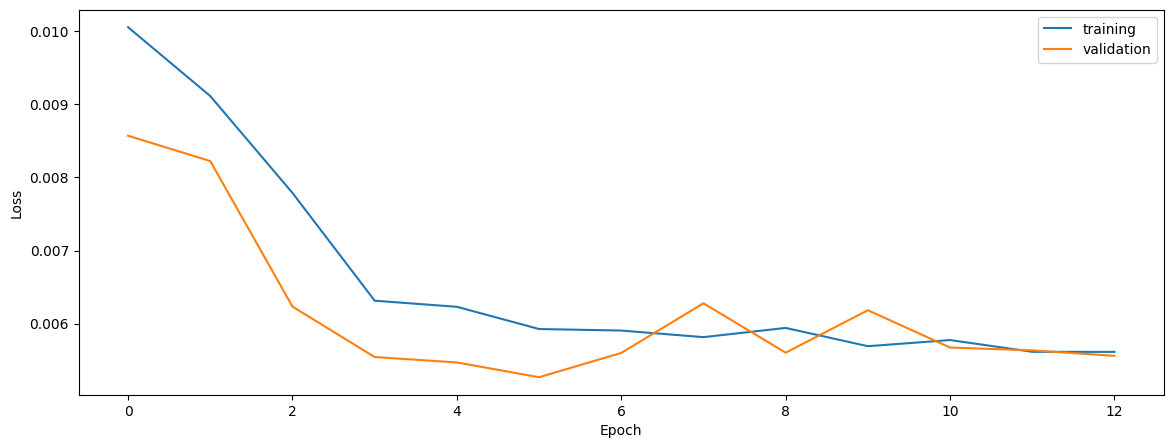

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


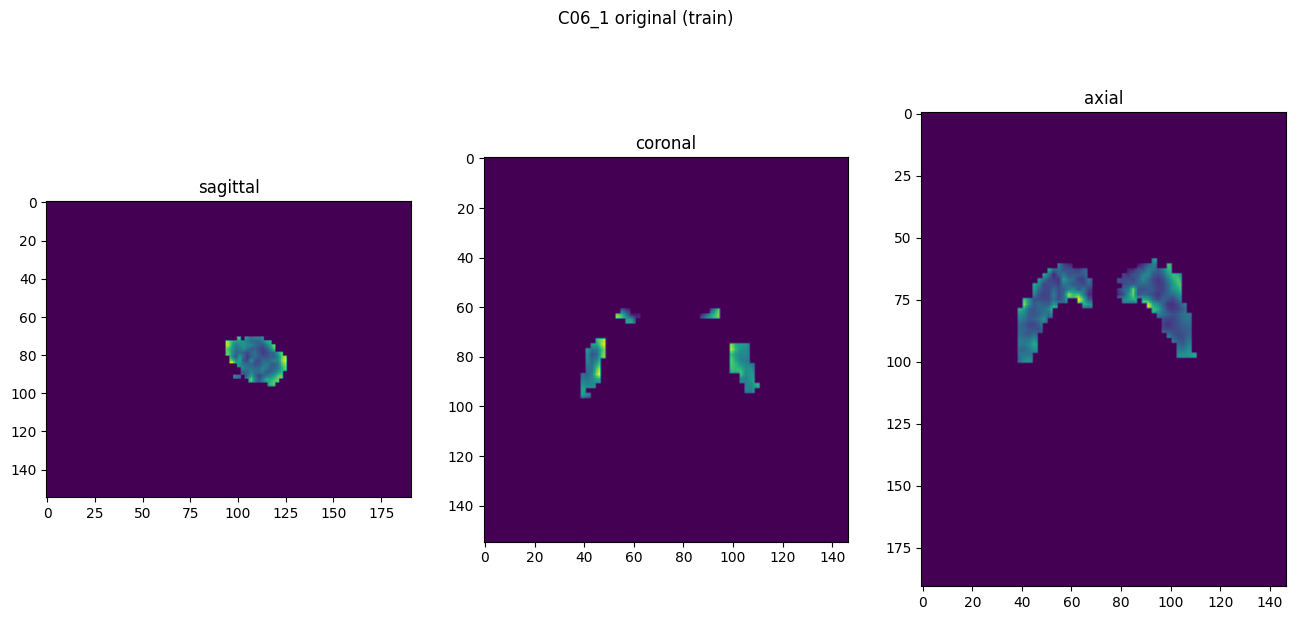

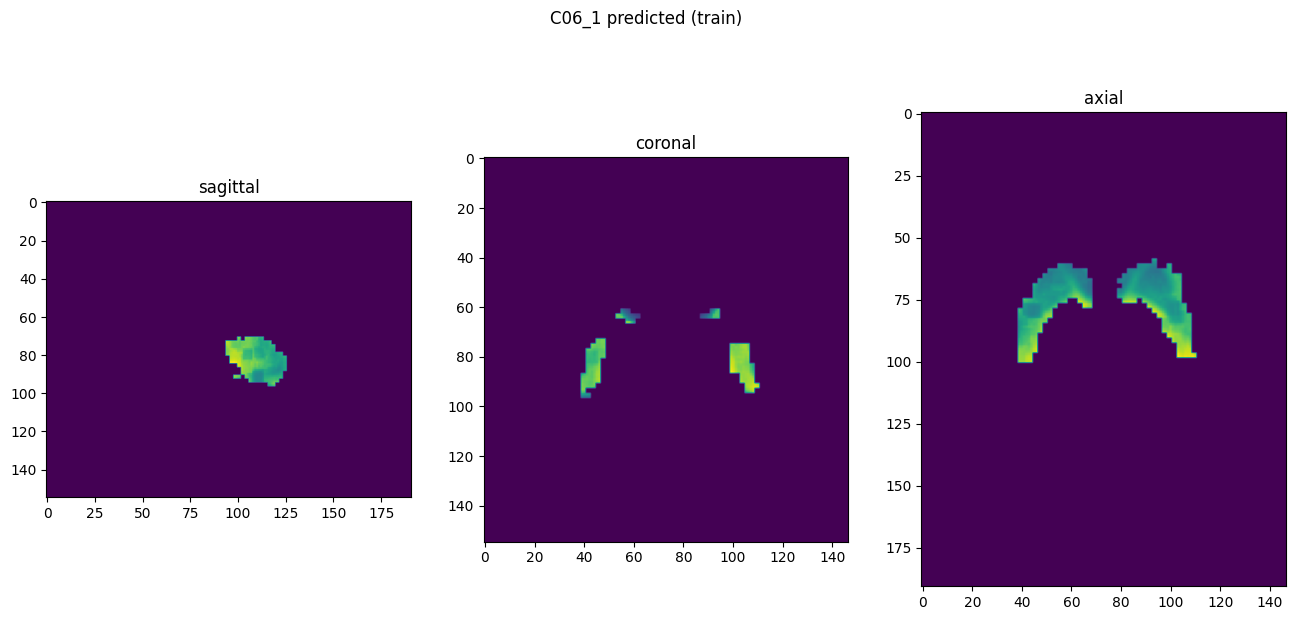

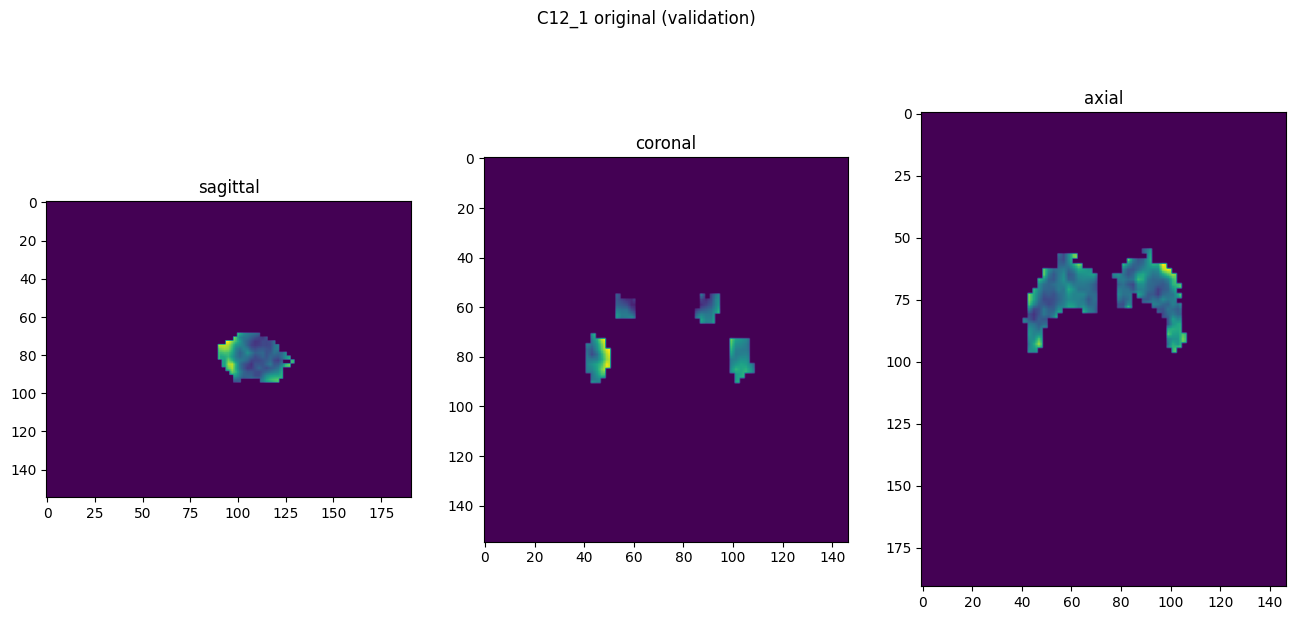

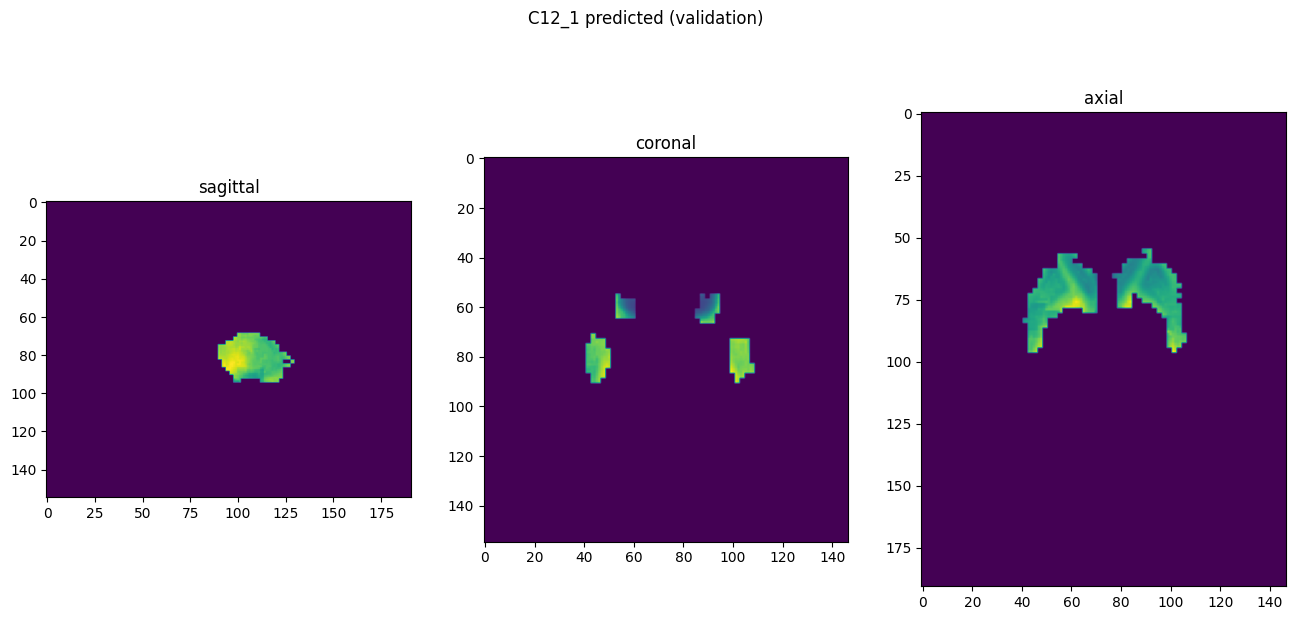

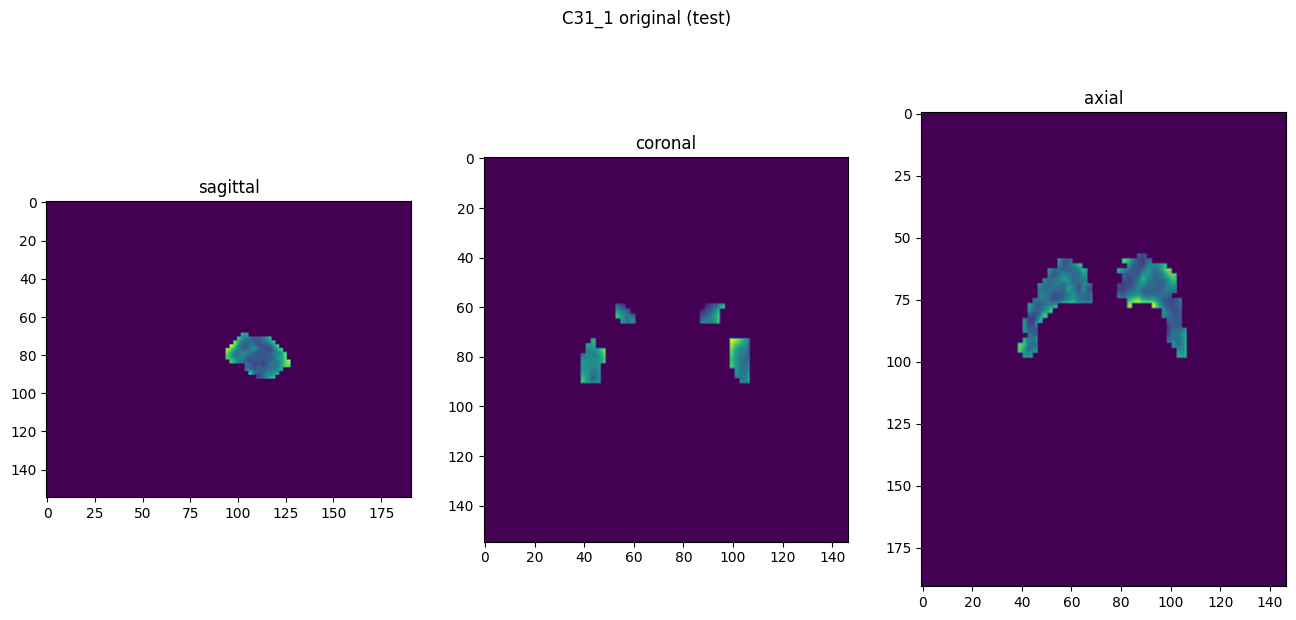

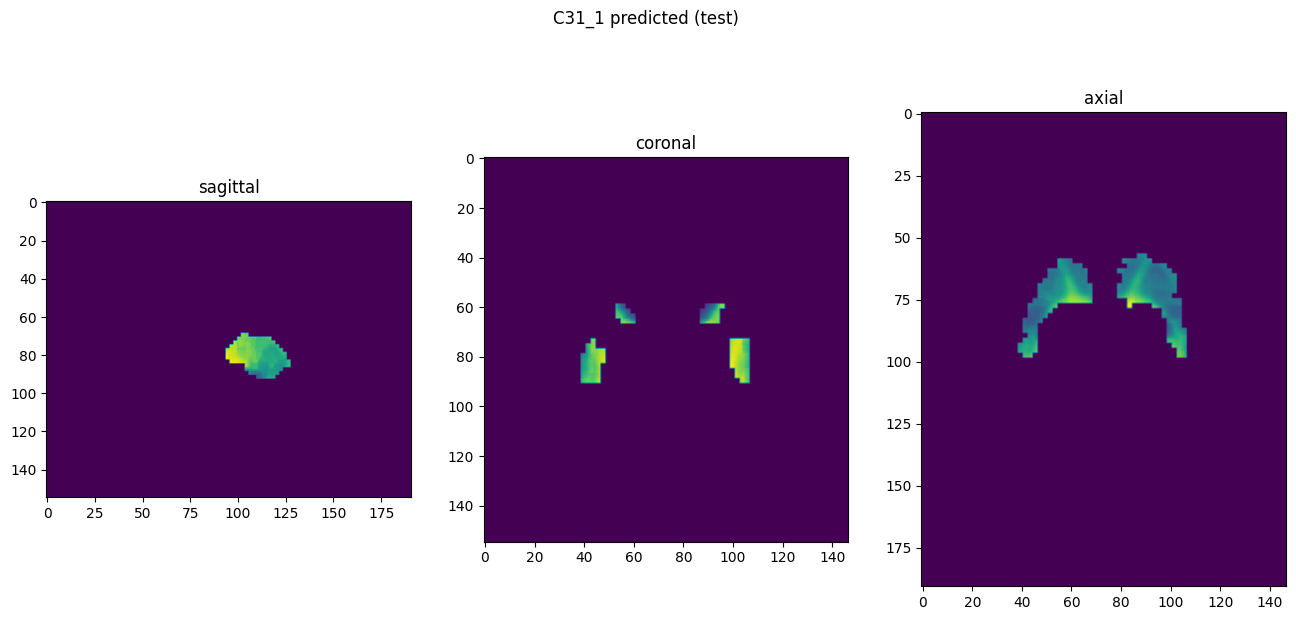

In [10]:
showResults(model, gen, threshold=None, background=False)